# Score weak classifiers
## Import libraries

In [1]:
import pandas as pd
import re
from pathlib import Path
from constants import PROJECT_PATH, TOKENIZER_SUFFIXES
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from constants import PLOT_PATH
import matplotlib

#colours = reversed(['#56B4E9', '#0072B2', '#E69F00', '#D55E00'])
colours = reversed(['#332288', '#117733', '#44AA99', '#88CCEE', '#7bafde', '#1965B0', '#AA4499', '#882255'])
matplotlib.rcParams['axes.prop_cycle'] = cycler('color', colours)

/home/jgut/miniconda3/envs/SMILES_OR_SELFIES/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/jgut/miniconda3/envs/SMILES_OR_SELFIES/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Define useful classes

In [89]:
import ast
import json
import re
from statistics import mean, stdev

def clean_string(string:str):
    string = re.sub(r"\'param\_.*\)\,\'params\'", "'params'",string)
    string = string.replace("array([", "[").replace("])", "]")
    string = re.sub(r"\],\s*dtype=.*\),", "],",string)
    return string

def reading_dict(path:Path):
    with open(path, 'r') as f:
        lines = f.readlines()
    #skip first line with estimator name
    return lines[0].strip(), ast.literal_eval(clean_string("".join([line.strip() for line in lines[1:]])))

def get_cells(line:str)->[str]:
    return [cell.strip() for cell in re.split("  ", line) if len(cell)>0]

def parse_dict(dikt:dict):
    best_model_index = dikt['rank_test_score'].index(1)
    best_params = dikt["params"][best_model_index]
    best_scores = []
    for i in range(3):
        best_scores.append(abs(float(dikt[f"split{i}_test_score"][best_model_index])))
    return best_params, mean(best_scores), stdev(best_scores)

def get_report(path:Path):
    estimator, dikt = reading_dict(path)
    best_params, mean_best_scores, std_best_scores = parse_dict(dikt)
    return {"estimator": estimator, "best_params":best_params, "best_scores": mean_best_scores, "std": std_best_scores,}

def parse_tokenizer(tokenizer_string:str):
    """Parse tokenizer string

    Args:
        tokenizer_string (str): tokenizer string to parse

    Returns:
        Dict[str, str]: dictionary with tokenizer settings
    """
    tokenizer_parts = tokenizer_string.split("_")
    output = {
        "embedding": tokenizer_parts[0],
        "tokenizer": tokenizer_parts[1],
        "dataset": tokenizer_parts[2],
    }
    return output
interesting_rows = [['selfies', 'atom','standard','roberta'],['smiles', 'atom','standard','roberta'], ['selfies','atom','standard','bart'], ['smiles', 'atom','standard','bart'],]

## Compute dataframe

In [90]:
entries = []
for descriptor_name in ["Chi0v","Heterocycles", "NumHDonors","Kappa1", "MolLogP", "MolMR", "QED"]:
    for tokenizer_suffix in TOKENIZER_SUFFIXES:
        for model in ["bart", "roberta"]:
            report_parent_path = PROJECT_PATH / f"embeddings_{model}" / descriptor_name / tokenizer_suffix / "reports"
            if not report_parent_path.exists():
                continue
            for estimators_file in report_parent_path.glob("*.txt"):
                entry = {"descriptor": descriptor_name, "architecture": model} | parse_tokenizer(tokenizer_suffix) | get_report(estimators_file) 
                entries.append(entry)
df = pd.DataFrame(entries)
df

,descriptor,architecture,embedding,tokenizer,dataset,estimator,best_params,best_scores,std
0,Chi0v,bart,smiles,atom,isomers,Linear SVR,{'C': 10},2.763345,0.165463
1,Chi0v,bart,smiles,atom,isomers,RBF SVR,{'C': 10},1.959920,0.195276
2,Chi0v,bart,smiles,atom,isomers,KNN,"{'n_neighbors': 5, 'weights': 'distance'}",2.766800,0.046068
3,Chi0v,roberta,smiles,atom,isomers,Linear SVR,{'C': 10},4.096843,0.618092
4,Chi0v,roberta,smiles,atom,isomers,RBF SVR,{'C': 10},3.246423,0.176958
...,...,...,...,...,...,...,...,...,...
331,QED,bart,selfies,trained,standard,RBF SVR,{'C': 1},0.113933,0.000147
332,QED,bart,selfies,trained,standard,KNN,"{'n_neighbors': 11, 'weights': 'distance'}",0.150011,0.001892
333,QED,roberta,selfies,trained,standard,Linear SVR,{'C': 1},0.157207,0.016986
334,QED,roberta,selfies,trained,standard,RBF SVR,{'C': 1},0.115321,0.000150


## Diced by estimator

In [92]:
for estimator in df.estimator.unique():
    for descriptor in df.descriptor.unique(): 
        print(f"Estimator {estimator}, descriptor {descriptor}")
        display(df[["descriptor","embedding","tokenizer","dataset","estimator", "best_scores","std","architecture"]][df.estimator==estimator][df.descriptor==descriptor].sort_values("best_scores"))
        print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))

Estimator Linear SVR, descriptor Chi0v


/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding","tokenizer","dataset","estimator", "best_scores","std","architecture"]][df.estimator==estimator][df.descriptor==descriptor].sort_values("best_scores"))


,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
6,Chi0v,smiles,atom,standard,Linear SVR,2.617720,0.194198,bart
0,Chi0v,smiles,atom,isomers,Linear SVR,2.763345,0.165463,bart
24,Chi0v,selfies,atom,isomers,Linear SVR,2.802106,0.112073,bart
45,Chi0v,selfies,trained,standard,Linear SVR,2.868106,0.186013,roberta
30,Chi0v,selfies,atom,standard,Linear SVR,2.894233,0.255244,bart
21,Chi0v,smiles,trained,standard,Linear SVR,2.986995,0.108746,roberta
36,Chi0v,selfies,trained,isomers,Linear SVR,3.101085,0.273802,bart
18,Chi0v,smiles,trained,standard,Linear SVR,3.322796,0.183739,bart
42,Chi0v,selfies,trained,standard,Linear SVR,3.353104,0.197644,bart
12,Chi0v,smiles,trained,isomers,Linear SVR,3.364736,0.175960,bart


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset &   estimator & architecture &  best\_scores &   std \\
\midrule
0  &      Chi0v &    smiles &      atom &   isomers &  Linear SVR &         bart &        2.763 & 0.165 \\
3  &      Chi0v &    smiles &      atom &   isomers &  Linear SVR &      roberta &        4.097 & 0.618 \\
6  &      Chi0v &    smiles &      atom &  standard &  Linear SVR &         bart &        2.618 & 0.194 \\
9  &      Chi0v &    smiles &      atom &  standard &  Linear SVR &      roberta &        3.863 & 0.181 \\
12 &      Chi0v &    smiles &   trained &   isomers &  Linear SVR &         bart &        3.365 & 0.176 \\
15 &      Chi0v &    smiles &   trained &   isomers &  Linear SVR &      roberta &        4.139 & 0.125 \\
18 &      Chi0v &    smiles &   trained &  standard &  Linear SVR &         bart &        3.323 & 0.184 \\
21 &      Chi0v &    smiles &   trained &  standard &  Linear SVR &      roberta &        2.987 & 

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator Linear SVR, descriptor NumHDonors


/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator Linear SVR, descriptor Kappa1


/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
165,Kappa1,smiles,trained,standard,Linear SVR,3.580501,0.165813,roberta
144,Kappa1,smiles,atom,isomers,Linear SVR,3.808398,0.283795,bart
174,Kappa1,selfies,atom,standard,Linear SVR,3.944261,0.246412,bart
183,Kappa1,selfies,trained,isomers,Linear SVR,4.025030,0.182383,roberta
168,Kappa1,selfies,atom,isomers,Linear SVR,4.037760,0.233672,bart
150,Kappa1,smiles,atom,standard,Linear SVR,4.140094,0.503569,bart
189,Kappa1,selfies,trained,standard,Linear SVR,4.269668,1.105563,roberta
180,Kappa1,selfies,trained,isomers,Linear SVR,4.468785,0.358004,bart
162,Kappa1,smiles,trained,standard,Linear SVR,4.582692,0.291953,bart
156,Kappa1,smiles,trained,isomers,Linear SVR,4.642563,0.266465,bart


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset &   estimator & architecture &  best\_scores &   std \\
\midrule
144 &     Kappa1 &    smiles &      atom &   isomers &  Linear SVR &         bart &        3.808 & 0.284 \\
147 &     Kappa1 &    smiles &      atom &   isomers &  Linear SVR &      roberta &        5.027 & 0.259 \\
150 &     Kappa1 &    smiles &      atom &  standard &  Linear SVR &         bart &        4.140 & 0.504 \\
153 &     Kappa1 &    smiles &      atom &  standard &  Linear SVR &      roberta &        5.389 & 0.329 \\
156 &     Kappa1 &    smiles &   trained &   isomers &  Linear SVR &         bart &        4.643 & 0.266 \\
159 &     Kappa1 &    smiles &   trained &   isomers &  Linear SVR &      roberta &        5.543 & 0.186 \\
162 &     Kappa1 &    smiles &   trained &  standard &  Linear SVR &         bart &        4.583 & 0.292 \\
165 &     Kappa1 &    smiles &   trained &  standard &  Linear SVR &      roberta &        

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
192,MolLogP,smiles,atom,isomers,Linear SVR,1.389949,0.036478,bart
198,MolLogP,smiles,atom,standard,Linear SVR,1.401448,0.042081,bart
222,MolLogP,selfies,atom,standard,Linear SVR,1.447351,0.029761,bart
216,MolLogP,selfies,atom,isomers,Linear SVR,1.518293,0.034230,bart
237,MolLogP,selfies,trained,standard,Linear SVR,1.575939,0.010925,roberta
228,MolLogP,selfies,trained,isomers,Linear SVR,1.598333,0.036909,bart
210,MolLogP,smiles,trained,standard,Linear SVR,1.625082,0.027963,bart
234,MolLogP,selfies,trained,standard,Linear SVR,1.659722,0.030368,bart
204,MolLogP,smiles,trained,isomers,Linear SVR,1.664166,0.029811,bart
213,MolLogP,smiles,trained,standard,Linear SVR,1.671375,0.003648,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset &   estimator & architecture &  best\_scores &   std \\
\midrule
192 &    MolLogP &    smiles &      atom &   isomers &  Linear SVR &         bart &        1.390 & 0.036 \\
195 &    MolLogP &    smiles &      atom &   isomers &  Linear SVR &      roberta &        1.870 & 0.074 \\
198 &    MolLogP &    smiles &      atom &  standard &  Linear SVR &         bart &        1.401 & 0.042 \\
201 &    MolLogP &    smiles &      atom &  standard &  Linear SVR &      roberta &        1.956 & 0.021 \\
204 &    MolLogP &    smiles &   trained &   isomers &  Linear SVR &         bart &        1.664 & 0.030 \\
207 &    MolLogP &    smiles &   trained &   isomers &  Linear SVR &      roberta &        1.911 & 0.006 \\
210 &    MolLogP &    smiles &   trained &  standard &  Linear SVR &         bart &        1.625 & 0.028 \\
213 &    MolLogP &    smiles &   trained &  standard &  Linear SVR &      roberta &        

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
246,MolMR,smiles,atom,standard,Linear SVR,18.642732,1.302136,bart
261,MolMR,smiles,trained,standard,Linear SVR,18.929302,0.641563,roberta
240,MolMR,smiles,atom,isomers,Linear SVR,19.109736,1.371120,bart
285,MolMR,selfies,trained,standard,Linear SVR,19.515618,1.255197,roberta
270,MolMR,selfies,atom,standard,Linear SVR,19.540211,1.368968,bart
264,MolMR,selfies,atom,isomers,Linear SVR,19.762594,1.433054,bart
276,MolMR,selfies,trained,isomers,Linear SVR,20.436391,1.506140,bart
258,MolMR,smiles,trained,standard,Linear SVR,21.054834,1.110580,bart
282,MolMR,selfies,trained,standard,Linear SVR,21.259305,1.481697,bart
252,MolMR,smiles,trained,isomers,Linear SVR,21.451214,1.169087,bart


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset &   estimator & architecture &  best\_scores &   std \\
\midrule
240 &      MolMR &    smiles &      atom &   isomers &  Linear SVR &         bart &       19.110 & 1.371 \\
243 &      MolMR &    smiles &      atom &   isomers &  Linear SVR &      roberta &       25.396 & 1.966 \\
246 &      MolMR &    smiles &      atom &  standard &  Linear SVR &         bart &       18.643 & 1.302 \\
249 &      MolMR &    smiles &      atom &  standard &  Linear SVR &      roberta &       28.116 & 1.132 \\
252 &      MolMR &    smiles &   trained &   isomers &  Linear SVR &         bart &       21.451 & 1.169 \\
255 &      MolMR &    smiles &   trained &   isomers &  Linear SVR &      roberta &       26.732 & 0.806 \\
258 &      MolMR &    smiles &   trained &  standard &  Linear SVR &         bart &       21.055 & 1.111 \\
261 &      MolMR &    smiles &   trained &  standard &  Linear SVR &      roberta &       1

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
294,QED,smiles,atom,standard,Linear SVR,0.119091,0.001726,bart
318,QED,selfies,atom,standard,Linear SVR,0.126179,0.006366,bart
288,QED,smiles,atom,isomers,Linear SVR,0.128355,0.009038,bart
312,QED,selfies,atom,isomers,Linear SVR,0.139098,0.012288,bart
291,QED,smiles,atom,isomers,Linear SVR,0.140767,0.005746,roberta
324,QED,selfies,trained,isomers,Linear SVR,0.145159,0.004985,bart
297,QED,smiles,atom,standard,Linear SVR,0.147056,0.007650,roberta
330,QED,selfies,trained,standard,Linear SVR,0.147275,0.003020,bart
300,QED,smiles,trained,isomers,Linear SVR,0.148796,0.005347,bart
321,QED,selfies,atom,standard,Linear SVR,0.155410,0.016164,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset &   estimator & architecture &  best\_scores &   std \\
\midrule
288 &        QED &    smiles &      atom &   isomers &  Linear SVR &         bart &        0.128 & 0.009 \\
291 &        QED &    smiles &      atom &   isomers &  Linear SVR &      roberta &        0.141 & 0.006 \\
294 &        QED &    smiles &      atom &  standard &  Linear SVR &         bart &        0.119 & 0.002 \\
297 &        QED &    smiles &      atom &  standard &  Linear SVR &      roberta &        0.147 & 0.008 \\
300 &        QED &    smiles &   trained &   isomers &  Linear SVR &         bart &        0.149 & 0.005 \\
303 &        QED &    smiles &   trained &   isomers &  Linear SVR &      roberta &        0.167 & 0.016 \\
306 &        QED &    smiles &   trained &  standard &  Linear SVR &         bart &        0.161 & 0.016 \\
309 &        QED &    smiles &   trained &  standard &  Linear SVR &      roberta &        

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
25,Chi0v,selfies,atom,isomers,RBF SVR,1.819503,0.185988,bart
31,Chi0v,selfies,atom,standard,RBF SVR,1.851246,0.222392,bart
37,Chi0v,selfies,trained,isomers,RBF SVR,1.878941,0.253617,bart
7,Chi0v,smiles,atom,standard,RBF SVR,1.910585,0.197891,bart
1,Chi0v,smiles,atom,isomers,RBF SVR,1.959920,0.195276,bart
43,Chi0v,selfies,trained,standard,RBF SVR,2.086277,0.228725,bart
19,Chi0v,smiles,trained,standard,RBF SVR,2.211941,0.175322,bart
22,Chi0v,smiles,trained,standard,RBF SVR,2.294651,0.103958,roberta
13,Chi0v,smiles,trained,isomers,RBF SVR,2.336423,0.186257,bart
46,Chi0v,selfies,trained,standard,RBF SVR,2.452152,0.156661,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
1  &      Chi0v &    smiles &      atom &   isomers &   RBF SVR &         bart &        1.960 & 0.195 \\
4  &      Chi0v &    smiles &      atom &   isomers &   RBF SVR &      roberta &        3.246 & 0.177 \\
7  &      Chi0v &    smiles &      atom &  standard &   RBF SVR &         bart &        1.911 & 0.198 \\
10 &      Chi0v &    smiles &      atom &  standard &   RBF SVR &      roberta &        3.583 & 0.187 \\
13 &      Chi0v &    smiles &   trained &   isomers &   RBF SVR &         bart &        2.336 & 0.186 \\
16 &      Chi0v &    smiles &   trained &   isomers &   RBF SVR &      roberta &        3.286 & 0.135 \\
19 &      Chi0v &    smiles &   trained &  standard &   RBF SVR &         bart &        2.212 & 0.175 \\
22 &      Chi0v &    smiles &   trained &  standard &   RBF SVR &      roberta &        2.295 & 0.104 \\
25 &     

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator RBF SVR, descriptor NumHDonors


/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator RBF SVR, descriptor Kappa1


/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
169,Kappa1,selfies,atom,isomers,RBF SVR,2.728802,0.256032,bart
175,Kappa1,selfies,atom,standard,RBF SVR,2.757400,0.300414,bart
181,Kappa1,selfies,trained,isomers,RBF SVR,2.768409,0.336025,bart
145,Kappa1,smiles,atom,isomers,RBF SVR,2.805809,0.262021,bart
151,Kappa1,smiles,atom,standard,RBF SVR,2.816097,0.286067,bart
187,Kappa1,selfies,trained,standard,RBF SVR,3.001587,0.302060,bart
163,Kappa1,smiles,trained,standard,RBF SVR,3.197072,0.252289,bart
166,Kappa1,smiles,trained,standard,RBF SVR,3.324249,0.197020,roberta
157,Kappa1,smiles,trained,isomers,RBF SVR,3.340758,0.252801,bart
190,Kappa1,selfies,trained,standard,RBF SVR,3.455408,0.223653,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
145 &     Kappa1 &    smiles &      atom &   isomers &   RBF SVR &         bart &        2.806 & 0.262 \\
148 &     Kappa1 &    smiles &      atom &   isomers &   RBF SVR &      roberta &        4.535 & 0.245 \\
151 &     Kappa1 &    smiles &      atom &  standard &   RBF SVR &         bart &        2.816 & 0.286 \\
154 &     Kappa1 &    smiles &      atom &  standard &   RBF SVR &      roberta &        4.967 & 0.268 \\
157 &     Kappa1 &    smiles &   trained &   isomers &   RBF SVR &         bart &        3.341 & 0.253 \\
160 &     Kappa1 &    smiles &   trained &   isomers &   RBF SVR &      roberta &        4.599 & 0.212 \\
163 &     Kappa1 &    smiles &   trained &  standard &   RBF SVR &         bart &        3.197 & 0.252 \\
166 &     Kappa1 &    smiles &   trained &  standard &   RBF SVR &      roberta &        3.324 & 0.197 \\
1

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
193,MolLogP,smiles,atom,isomers,RBF SVR,0.968626,0.002752,bart
199,MolLogP,smiles,atom,standard,RBF SVR,0.975229,0.002995,bart
223,MolLogP,selfies,atom,standard,RBF SVR,1.008341,0.007389,bart
217,MolLogP,selfies,atom,isomers,RBF SVR,1.100513,0.007522,bart
229,MolLogP,selfies,trained,isomers,RBF SVR,1.131503,0.005996,bart
211,MolLogP,smiles,trained,standard,RBF SVR,1.144394,0.012065,bart
205,MolLogP,smiles,trained,isomers,RBF SVR,1.149129,0.009534,bart
235,MolLogP,selfies,trained,standard,RBF SVR,1.223434,0.012382,bart
238,MolLogP,selfies,trained,standard,RBF SVR,1.259246,0.008317,roberta
214,MolLogP,smiles,trained,standard,RBF SVR,1.280429,0.005339,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
193 &    MolLogP &    smiles &      atom &   isomers &   RBF SVR &         bart &        0.969 & 0.003 \\
196 &    MolLogP &    smiles &      atom &   isomers &   RBF SVR &      roberta &        1.511 & 0.013 \\
199 &    MolLogP &    smiles &      atom &  standard &   RBF SVR &         bart &        0.975 & 0.003 \\
202 &    MolLogP &    smiles &      atom &  standard &   RBF SVR &      roberta &        1.570 & 0.019 \\
205 &    MolLogP &    smiles &   trained &   isomers &   RBF SVR &         bart &        1.149 & 0.010 \\
208 &    MolLogP &    smiles &   trained &   isomers &   RBF SVR &      roberta &        1.575 & 0.009 \\
211 &    MolLogP &    smiles &   trained &  standard &   RBF SVR &         bart &        1.144 & 0.012 \\
214 &    MolLogP &    smiles &   trained &  standard &   RBF SVR &      roberta &        1.280 & 0.005 \\
2

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
247,MolMR,smiles,atom,standard,RBF SVR,16.753586,1.298317,bart
241,MolMR,smiles,atom,isomers,RBF SVR,16.878323,1.302993,bart
271,MolMR,selfies,atom,standard,RBF SVR,16.883001,1.368963,bart
277,MolMR,selfies,trained,isomers,RBF SVR,16.999871,1.605423,bart
265,MolMR,selfies,atom,isomers,RBF SVR,17.233746,1.319375,bart
283,MolMR,selfies,trained,standard,RBF SVR,17.837286,1.567993,bart
259,MolMR,smiles,trained,standard,RBF SVR,19.124995,1.247402,bart
286,MolMR,selfies,trained,standard,RBF SVR,19.421635,1.151297,roberta
253,MolMR,smiles,trained,isomers,RBF SVR,19.490523,1.225390,bart
262,MolMR,smiles,trained,standard,RBF SVR,20.142744,1.130048,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
241 &      MolMR &    smiles &      atom &   isomers &   RBF SVR &         bart &       16.878 & 1.303 \\
244 &      MolMR &    smiles &      atom &   isomers &   RBF SVR &      roberta &       24.977 & 1.130 \\
247 &      MolMR &    smiles &      atom &  standard &   RBF SVR &         bart &       16.754 & 1.298 \\
250 &      MolMR &    smiles &      atom &  standard &   RBF SVR &      roberta &       26.396 & 1.219 \\
253 &      MolMR &    smiles &   trained &   isomers &   RBF SVR &         bart &       19.491 & 1.225 \\
256 &      MolMR &    smiles &   trained &   isomers &   RBF SVR &      roberta &       25.250 & 0.955 \\
259 &      MolMR &    smiles &   trained &  standard &   RBF SVR &         bart &       19.125 & 1.247 \\
262 &      MolMR &    smiles &   trained &  standard &   RBF SVR &      roberta &       20.143 & 1.130 \\
2

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
289,QED,smiles,atom,isomers,RBF SVR,0.090253,0.000276,bart
295,QED,smiles,atom,standard,RBF SVR,0.091073,0.000276,bart
319,QED,selfies,atom,standard,RBF SVR,0.097414,0.000149,bart
313,QED,selfies,atom,isomers,RBF SVR,0.100365,0.000196,bart
307,QED,smiles,trained,standard,RBF SVR,0.106063,0.000150,bart
301,QED,smiles,trained,isomers,RBF SVR,0.106471,0.000573,bart
325,QED,selfies,trained,isomers,RBF SVR,0.108550,0.000357,bart
331,QED,selfies,trained,standard,RBF SVR,0.113933,0.000147,bart
310,QED,smiles,trained,standard,RBF SVR,0.114003,0.000131,roberta
334,QED,selfies,trained,standard,RBF SVR,0.115321,0.000150,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
289 &        QED &    smiles &      atom &   isomers &   RBF SVR &         bart &        0.090 & 0.000 \\
292 &        QED &    smiles &      atom &   isomers &   RBF SVR &      roberta &        0.116 & 0.000 \\
295 &        QED &    smiles &      atom &  standard &   RBF SVR &         bart &        0.091 & 0.000 \\
298 &        QED &    smiles &      atom &  standard &   RBF SVR &      roberta &        0.118 & 0.000 \\
301 &        QED &    smiles &   trained &   isomers &   RBF SVR &         bart &        0.106 & 0.001 \\
304 &        QED &    smiles &   trained &   isomers &   RBF SVR &      roberta &        0.127 & 0.000 \\
307 &        QED &    smiles &   trained &  standard &   RBF SVR &         bart &        0.106 & 0.000 \\
310 &        QED &    smiles &   trained &  standard &   RBF SVR &      roberta &        0.114 & 0.000 \\
3

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
32,Chi0v,selfies,atom,standard,KNN,2.600522,0.106590,bart
26,Chi0v,selfies,atom,isomers,KNN,2.697231,0.122454,bart
38,Chi0v,selfies,trained,isomers,KNN,2.715818,0.112880,bart
2,Chi0v,smiles,atom,isomers,KNN,2.766800,0.046068,bart
8,Chi0v,smiles,atom,standard,KNN,2.826439,0.061569,bart
44,Chi0v,selfies,trained,standard,KNN,2.919809,0.120229,bart
47,Chi0v,selfies,trained,standard,KNN,3.207955,0.108113,roberta
41,Chi0v,selfies,trained,isomers,KNN,3.323562,0.115411,roberta
23,Chi0v,smiles,trained,standard,KNN,3.391477,0.044258,roberta
29,Chi0v,selfies,atom,isomers,KNN,3.590770,0.200822,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
2  &      Chi0v &    smiles &      atom &   isomers &       KNN &         bart &        2.767 & 0.046 \\
5  &      Chi0v &    smiles &      atom &   isomers &       KNN &      roberta &        3.950 & 0.148 \\
8  &      Chi0v &    smiles &      atom &  standard &       KNN &         bart &        2.826 & 0.062 \\
11 &      Chi0v &    smiles &      atom &  standard &       KNN &      roberta &        4.230 & 0.183 \\
14 &      Chi0v &    smiles &   trained &   isomers &       KNN &         bart &        3.898 & 0.123 \\
17 &      Chi0v &    smiles &   trained &   isomers &       KNN &      roberta &        3.927 & 0.129 \\
20 &      Chi0v &    smiles &   trained &  standard &       KNN &         bart &        3.874 & 0.161 \\
23 &      Chi0v &    smiles &   trained &  standard &       KNN &      roberta &        3.391 & 0.044 \\
26 &     

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
92,Heterocycles,selfies,trained,standard,KNN,0.76843,0.000564,bart
77,Heterocycles,selfies,atom,isomers,KNN,0.78064,0.001196,roberta
89,Heterocycles,selfies,trained,isomers,KNN,0.78124,0.001487,roberta
95,Heterocycles,selfies,trained,standard,KNN,0.78681,0.003741,roberta
59,Heterocycles,smiles,atom,standard,KNN,0.79629,0.001452,roberta
86,Heterocycles,selfies,trained,isomers,KNN,0.79764,0.002128,bart
53,Heterocycles,smiles,atom,isomers,KNN,0.80229,0.002357,roberta
83,Heterocycles,selfies,atom,standard,KNN,0.80777,0.001119,roberta
74,Heterocycles,selfies,atom,isomers,KNN,0.81803,0.002112,bart
80,Heterocycles,selfies,atom,standard,KNN,0.82063,0.002110,bart


\begin{tabular}{lllllllrr}
\toprule
{} &    descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
50 &  Heterocycles &    smiles &      atom &   isomers &       KNN &         bart &        0.856 & 0.001 \\
53 &  Heterocycles &    smiles &      atom &   isomers &       KNN &      roberta &        0.802 & 0.002 \\
56 &  Heterocycles &    smiles &      atom &  standard &       KNN &         bart &        0.858 & 0.002 \\
59 &  Heterocycles &    smiles &      atom &  standard &       KNN &      roberta &        0.796 & 0.001 \\
62 &  Heterocycles &    smiles &   trained &   isomers &       KNN &         bart &        0.843 & 0.001 \\
65 &  Heterocycles &    smiles &   trained &   isomers &       KNN &      roberta &        0.824 & 0.002 \\
68 &  Heterocycles &    smiles &   trained &  standard &       KNN &         bart &        0.846 & 0.002 \\
71 &  Heterocycles &    smiles &   trained &  standard &       KNN &      roberta &       

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
137,NumHDonors,selfies,trained,isomers,KNN,0.62551,0.004562,roberta
125,NumHDonors,selfies,atom,isomers,KNN,0.63077,0.001707,roberta
143,NumHDonors,selfies,trained,standard,KNN,0.64775,0.001322,roberta
107,NumHDonors,smiles,atom,standard,KNN,0.65509,0.004465,roberta
101,NumHDonors,smiles,atom,isomers,KNN,0.65540,0.000952,roberta
119,NumHDonors,smiles,trained,standard,KNN,0.65677,0.002779,roberta
131,NumHDonors,selfies,atom,standard,KNN,0.66106,0.003105,roberta
122,NumHDonors,selfies,atom,isomers,KNN,0.67068,0.001188,bart
140,NumHDonors,selfies,trained,standard,KNN,0.67238,0.006323,bart
134,NumHDonors,selfies,trained,isomers,KNN,0.67346,0.001341,bart


\begin{tabular}{lllllllrr}
\toprule
{} &  descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
98  &  NumHDonors &    smiles &      atom &   isomers &       KNN &         bart &        0.731 & 0.003 \\
101 &  NumHDonors &    smiles &      atom &   isomers &       KNN &      roberta &        0.655 & 0.001 \\
104 &  NumHDonors &    smiles &      atom &  standard &       KNN &         bart &        0.720 & 0.003 \\
107 &  NumHDonors &    smiles &      atom &  standard &       KNN &      roberta &        0.655 & 0.004 \\
110 &  NumHDonors &    smiles &   trained &   isomers &       KNN &         bart &        0.719 & 0.004 \\
113 &  NumHDonors &    smiles &   trained &   isomers &       KNN &      roberta &        0.683 & 0.003 \\
116 &  NumHDonors &    smiles &   trained &  standard &       KNN &         bart &        0.705 & 0.003 \\
119 &  NumHDonors &    smiles &   trained &  standard &       KNN &      roberta &        0.657 & 0

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
176,Kappa1,selfies,atom,standard,KNN,3.498967,0.135122,bart
182,Kappa1,selfies,trained,isomers,KNN,3.566267,0.146979,bart
146,Kappa1,smiles,atom,isomers,KNN,3.571412,0.033880,bart
170,Kappa1,selfies,atom,isomers,KNN,3.613996,0.162337,bart
152,Kappa1,smiles,atom,standard,KNN,3.698012,0.064805,bart
188,Kappa1,selfies,trained,standard,KNN,3.844262,0.173935,bart
191,Kappa1,selfies,trained,standard,KNN,4.252472,0.160247,roberta
185,Kappa1,selfies,trained,isomers,KNN,4.436885,0.155894,roberta
167,Kappa1,smiles,trained,standard,KNN,4.564888,0.053490,roberta
173,Kappa1,selfies,atom,isomers,KNN,4.851059,0.279334,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
146 &     Kappa1 &    smiles &      atom &   isomers &       KNN &         bart &        3.571 & 0.034 \\
149 &     Kappa1 &    smiles &      atom &   isomers &       KNN &      roberta &        5.234 & 0.227 \\
152 &     Kappa1 &    smiles &      atom &  standard &       KNN &         bart &        3.698 & 0.065 \\
155 &     Kappa1 &    smiles &      atom &  standard &       KNN &      roberta &        5.595 & 0.277 \\
158 &     Kappa1 &    smiles &   trained &   isomers &       KNN &         bart &        5.096 & 0.180 \\
161 &     Kappa1 &    smiles &   trained &   isomers &       KNN &      roberta &        5.242 & 0.204 \\
164 &     Kappa1 &    smiles &   trained &  standard &       KNN &         bart &        5.093 & 0.246 \\
167 &     Kappa1 &    smiles &   trained &  standard &       KNN &      roberta &        4.565 & 0.053 \\
1

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
200,MolLogP,smiles,atom,standard,KNN,1.706380,0.011529,bart
194,MolLogP,smiles,atom,isomers,KNN,1.723196,0.004932,bart
224,MolLogP,selfies,atom,standard,KNN,1.800952,0.009086,bart
230,MolLogP,selfies,trained,isomers,KNN,1.804803,0.035281,bart
239,MolLogP,selfies,trained,standard,KNN,1.822293,0.009346,roberta
236,MolLogP,selfies,trained,standard,KNN,1.844711,0.021441,bart
218,MolLogP,selfies,atom,isomers,KNN,1.848410,0.007441,bart
227,MolLogP,selfies,atom,standard,KNN,1.890904,0.007663,roberta
206,MolLogP,smiles,trained,isomers,KNN,1.895302,0.016187,bart
212,MolLogP,smiles,trained,standard,KNN,1.902491,0.011084,bart


/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
194 &    MolLogP &    smiles &      atom &   isomers &       KNN &         bart &        1.723 & 0.005 \\
197 &    MolLogP &    smiles &      atom &   isomers &       KNN &      roberta &        1.954 & 0.022 \\
200 &    MolLogP &    smiles &      atom &  standard &       KNN &         bart &        1.706 & 0.012 \\
203 &    MolLogP &    smiles &      atom &  standard &       KNN &      roberta &        1.984 & 0.033 \\
206 &    MolLogP &    smiles &   trained &   isomers &       KNN &         bart &        1.895 & 0.016 \\
209 &    MolLogP &    smiles &   trained &   isomers &       KNN &      roberta &        1.997 & 0.013 \\
212 &    MolLogP &    smiles &   trained &  standard &       KNN &         bart &        1.902 & 0.011 \\
215 &    MolLogP &    smiles &   trained &  standard &       KNN &      roberta &        1.911 & 0.003 \\
2

/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding","tokenizer","dataset","estimator", "best_scores","std","architecture"]][df.estimator==estimator][df.descriptor==descriptor].sort_values("best_scores"))


,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
272,MolMR,selfies,atom,standard,KNN,16.772547,0.765700,bart
266,MolMR,selfies,atom,isomers,KNN,17.384783,0.959355,bart
278,MolMR,selfies,trained,isomers,KNN,17.558058,0.850600,bart
242,MolMR,smiles,atom,isomers,KNN,18.006044,0.537695,bart
248,MolMR,smiles,atom,standard,KNN,18.083995,0.620911,bart
284,MolMR,selfies,trained,standard,KNN,18.899588,0.860780,bart
287,MolMR,selfies,trained,standard,KNN,20.548952,0.703068,roberta
281,MolMR,selfies,trained,isomers,KNN,21.472718,0.915621,roberta
263,MolMR,smiles,trained,standard,KNN,21.913585,0.389124,roberta
269,MolMR,selfies,atom,isomers,KNN,22.930477,1.313636,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
242 &      MolMR &    smiles &      atom &   isomers &       KNN &         bart &       18.006 & 0.538 \\
245 &      MolMR &    smiles &      atom &   isomers &       KNN &      roberta &       25.404 & 0.973 \\
248 &      MolMR &    smiles &      atom &  standard &       KNN &         bart &       18.084 & 0.621 \\
251 &      MolMR &    smiles &      atom &  standard &       KNN &      roberta &       27.146 & 1.183 \\
254 &      MolMR &    smiles &   trained &   isomers &       KNN &         bart &       25.294 & 0.883 \\
257 &      MolMR &    smiles &   trained &   isomers &       KNN &      roberta &       25.614 & 0.880 \\
260 &      MolMR &    smiles &   trained &  standard &       KNN &         bart &       25.137 & 1.050 \\
263 &      MolMR &    smiles &   trained &  standard &       KNN &      roberta &       21.914 & 0.389 \\
2

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
290,QED,smiles,atom,isomers,KNN,0.133783,0.001931,bart
296,QED,smiles,atom,standard,KNN,0.134146,0.001938,bart
320,QED,selfies,atom,standard,KNN,0.137968,0.001576,bart
314,QED,selfies,atom,isomers,KNN,0.143122,0.001705,bart
326,QED,selfies,trained,isomers,KNN,0.146542,0.001943,bart
335,QED,selfies,trained,standard,KNN,0.149566,0.000291,roberta
332,QED,selfies,trained,standard,KNN,0.150011,0.001892,bart
323,QED,selfies,atom,standard,KNN,0.150188,0.000323,roberta
305,QED,smiles,trained,isomers,KNN,0.150688,0.000227,roberta
317,QED,selfies,atom,isomers,KNN,0.152052,0.000707,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
290 &        QED &    smiles &      atom &   isomers &       KNN &         bart &        0.134 & 0.002 \\
293 &        QED &    smiles &      atom &   isomers &       KNN &      roberta &        0.153 & 0.001 \\
296 &        QED &    smiles &      atom &  standard &       KNN &         bart &        0.134 & 0.002 \\
299 &        QED &    smiles &      atom &  standard &       KNN &      roberta &        0.156 & 0.001 \\
302 &        QED &    smiles &   trained &   isomers &       KNN &         bart &        0.153 & 0.002 \\
305 &        QED &    smiles &   trained &   isomers &       KNN &      roberta &        0.151 & 0.000 \\
308 &        QED &    smiles &   trained &  standard &       KNN &         bart &        0.157 & 0.002 \\
311 &        QED &    smiles &   trained &  standard &       KNN &      roberta &        0.153 & 0.000 \\
3

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator RBF SVC, descriptor Heterocycles


,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
75,Heterocycles,selfies,atom,isomers,RBF SVC,0.86844,0.000963,roberta
87,Heterocycles,selfies,trained,isomers,RBF SVC,0.88432,0.000560,roberta
81,Heterocycles,selfies,atom,standard,RBF SVC,0.88936,0.001246,roberta
57,Heterocycles,smiles,atom,standard,RBF SVC,0.89087,0.000617,roberta
90,Heterocycles,selfies,trained,standard,RBF SVC,0.89477,0.001578,bart
93,Heterocycles,selfies,trained,standard,RBF SVC,0.89512,0.001187,roberta
51,Heterocycles,smiles,atom,isomers,RBF SVC,0.89924,0.000390,roberta
63,Heterocycles,smiles,trained,isomers,RBF SVC,0.90375,0.001833,roberta
84,Heterocycles,selfies,trained,isomers,RBF SVC,0.90868,0.000364,bart
69,Heterocycles,smiles,trained,standard,RBF SVC,0.92791,0.000981,roberta


/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

\begin{tabular}{lllllllrr}
\toprule
{} &    descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
48 &  Heterocycles &    smiles &      atom &   isomers &   RBF SVC &         bart &        0.962 & 0.002 \\
51 &  Heterocycles &    smiles &      atom &   isomers &   RBF SVC &      roberta &        0.899 & 0.000 \\
54 &  Heterocycles &    smiles &      atom &  standard &   RBF SVC &         bart &        0.962 & 0.001 \\
57 &  Heterocycles &    smiles &      atom &  standard &   RBF SVC &      roberta &        0.891 & 0.001 \\
60 &  Heterocycles &    smiles &   trained &   isomers &   RBF SVC &         bart &        0.950 & 0.001 \\
63 &  Heterocycles &    smiles &   trained &   isomers &   RBF SVC &      roberta &        0.904 & 0.002 \\
66 &  Heterocycles &    smiles &   trained &  standard &   RBF SVC &         bart &        0.949 & 0.001 \\
69 &  Heterocycles &    smiles &   trained &  standard &   RBF SVC &      roberta &       

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
123,NumHDonors,selfies,atom,isomers,RBF SVC,0.74300,0.003890,roberta
129,NumHDonors,selfies,atom,standard,RBF SVC,0.77389,0.002498,roberta
135,NumHDonors,selfies,trained,isomers,RBF SVC,0.78009,0.002171,roberta
105,NumHDonors,smiles,atom,standard,RBF SVC,0.79285,0.003510,roberta
99,NumHDonors,smiles,atom,isomers,RBF SVC,0.79802,0.003694,roberta
141,NumHDonors,selfies,trained,standard,RBF SVC,0.80264,0.002820,roberta
111,NumHDonors,smiles,trained,isomers,RBF SVC,0.81530,0.001879,roberta
138,NumHDonors,selfies,trained,standard,RBF SVC,0.81969,0.003112,bart
132,NumHDonors,selfies,trained,isomers,RBF SVC,0.82981,0.003072,bart
120,NumHDonors,selfies,atom,isomers,RBF SVC,0.84794,0.000943,bart


\begin{tabular}{lllllllrr}
\toprule
{} &  descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
96  &  NumHDonors &    smiles &      atom &   isomers &   RBF SVC &         bart &        0.900 & 0.001 \\
99  &  NumHDonors &    smiles &      atom &   isomers &   RBF SVC &      roberta &        0.798 & 0.004 \\
102 &  NumHDonors &    smiles &      atom &  standard &   RBF SVC &         bart &        0.891 & 0.002 \\
105 &  NumHDonors &    smiles &      atom &  standard &   RBF SVC &      roberta &        0.793 & 0.004 \\
108 &  NumHDonors &    smiles &   trained &   isomers &   RBF SVC &         bart &        0.907 & 0.002 \\
111 &  NumHDonors &    smiles &   trained &   isomers &   RBF SVC &      roberta &        0.815 & 0.002 \\
114 &  NumHDonors &    smiles &   trained &  standard &   RBF SVC &         bart &        0.900 & 0.002 \\
117 &  NumHDonors &    smiles &   trained &  standard &   RBF SVC &      roberta &        0.851 & 0

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator RBF SVC, descriptor MolLogP


/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator RBF SVC, descriptor MolMR


/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator RBF SVC, descriptor QED


/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator Linear SVC, descriptor Chi0v


/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator Linear SVC, descriptor Heterocycles


/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
76,Heterocycles,selfies,atom,isomers,Linear SVC,0.84122,0.001479,roberta
82,Heterocycles,selfies,atom,standard,Linear SVC,0.85606,0.001066,roberta
58,Heterocycles,smiles,atom,standard,Linear SVC,0.85712,0.000950,roberta
88,Heterocycles,selfies,trained,isomers,Linear SVC,0.86012,0.001086,roberta
91,Heterocycles,selfies,trained,standard,Linear SVC,0.86241,0.003291,bart
94,Heterocycles,selfies,trained,standard,Linear SVC,0.87048,0.000847,roberta
85,Heterocycles,selfies,trained,isomers,Linear SVC,0.87068,0.001047,bart
52,Heterocycles,smiles,atom,isomers,Linear SVC,0.87497,0.001602,roberta
64,Heterocycles,smiles,trained,isomers,Linear SVC,0.87666,0.000337,roberta
73,Heterocycles,selfies,atom,isomers,Linear SVC,0.89697,0.001949,bart


\begin{tabular}{lllllllrr}
\toprule
{} &    descriptor & embedding & tokenizer &   dataset &   estimator & architecture &  best\_scores &   std \\
\midrule
49 &  Heterocycles &    smiles &      atom &   isomers &  Linear SVC &         bart &        0.940 & 0.002 \\
52 &  Heterocycles &    smiles &      atom &   isomers &  Linear SVC &      roberta &        0.875 & 0.002 \\
55 &  Heterocycles &    smiles &      atom &  standard &  Linear SVC &         bart &        0.940 & 0.001 \\
58 &  Heterocycles &    smiles &      atom &  standard &  Linear SVC &      roberta &        0.857 & 0.001 \\
61 &  Heterocycles &    smiles &   trained &   isomers &  Linear SVC &         bart &        0.916 & 0.003 \\
64 &  Heterocycles &    smiles &   trained &   isomers &  Linear SVC &      roberta &        0.877 & 0.000 \\
67 &  Heterocycles &    smiles &   trained &  standard &  Linear SVC &         bart &        0.914 & 0.001 \\
70 &  Heterocycles &    smiles &   trained &  standard &  Linear SVC &    

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
124,NumHDonors,selfies,atom,isomers,Linear SVC,0.71271,0.000869,roberta
130,NumHDonors,selfies,atom,standard,Linear SVC,0.72868,0.001564,roberta
106,NumHDonors,smiles,atom,standard,Linear SVC,0.73813,0.000449,roberta
100,NumHDonors,smiles,atom,isomers,Linear SVC,0.75555,0.002061,roberta
136,NumHDonors,selfies,trained,isomers,Linear SVC,0.75856,0.000752,roberta
142,NumHDonors,selfies,trained,standard,Linear SVC,0.77545,0.003322,roberta
139,NumHDonors,selfies,trained,standard,Linear SVC,0.77839,0.001642,bart
133,NumHDonors,selfies,trained,isomers,Linear SVC,0.78448,0.001964,bart
112,NumHDonors,smiles,trained,isomers,Linear SVC,0.79064,0.003421,roberta
121,NumHDonors,selfies,atom,isomers,Linear SVC,0.79903,0.003525,bart


\begin{tabular}{lllllllrr}
\toprule
{} &  descriptor & embedding & tokenizer &   dataset &   estimator & architecture &  best\_scores &   std \\
\midrule
97  &  NumHDonors &    smiles &      atom &   isomers &  Linear SVC &         bart &        0.851 & 0.002 \\
100 &  NumHDonors &    smiles &      atom &   isomers &  Linear SVC &      roberta &        0.756 & 0.002 \\
103 &  NumHDonors &    smiles &      atom &  standard &  Linear SVC &         bart &        0.843 & 0.001 \\
106 &  NumHDonors &    smiles &      atom &  standard &  Linear SVC &      roberta &        0.738 & 0.000 \\
109 &  NumHDonors &    smiles &   trained &   isomers &  Linear SVC &         bart &        0.852 & 0.001 \\
112 &  NumHDonors &    smiles &   trained &   isomers &  Linear SVC &      roberta &        0.791 & 0.003 \\
115 &  NumHDonors &    smiles &   trained &  standard &  Linear SVC &         bart &        0.847 & 0.004 \\
118 &  NumHDonors &    smiles &   trained &  standard &  Linear SVC &      roberta 

/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator Linear SVC, descriptor MolLogP


/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator Linear SVC, descriptor MolMR


/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding"

\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator Linear SVC, descriptor QED


,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}



/tmp/ipykernel_661613/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_661613/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))


In [98]:
full_pivot = pd.pivot_table(df[df.estimator != "Logistic Regression"], values=["best_scores", "std"],index=["embedding","tokenizer","dataset","architecture"],columns=["descriptor","estimator"])

We see that for all of them, "atom" tokenizer performs better than "trained"/sentencepiece tokenizer and with a bigger impact SMILES performs better than SELFIES.

[0.00111928 0.00106646 0.00124631]
[0.00145157 0.00094951 0.00061695]
[0.00211046 0.00088858 0.00174925]
[0.0016843  0.00120882 0.00071699]
[0.00310499 0.00156407 0.00249787]
[0.00446501 0.00044883 0.00351019]
[0.00160501 0.00238542 0.00029371]
[0.00255003 0.00114436 0.0017367 ]


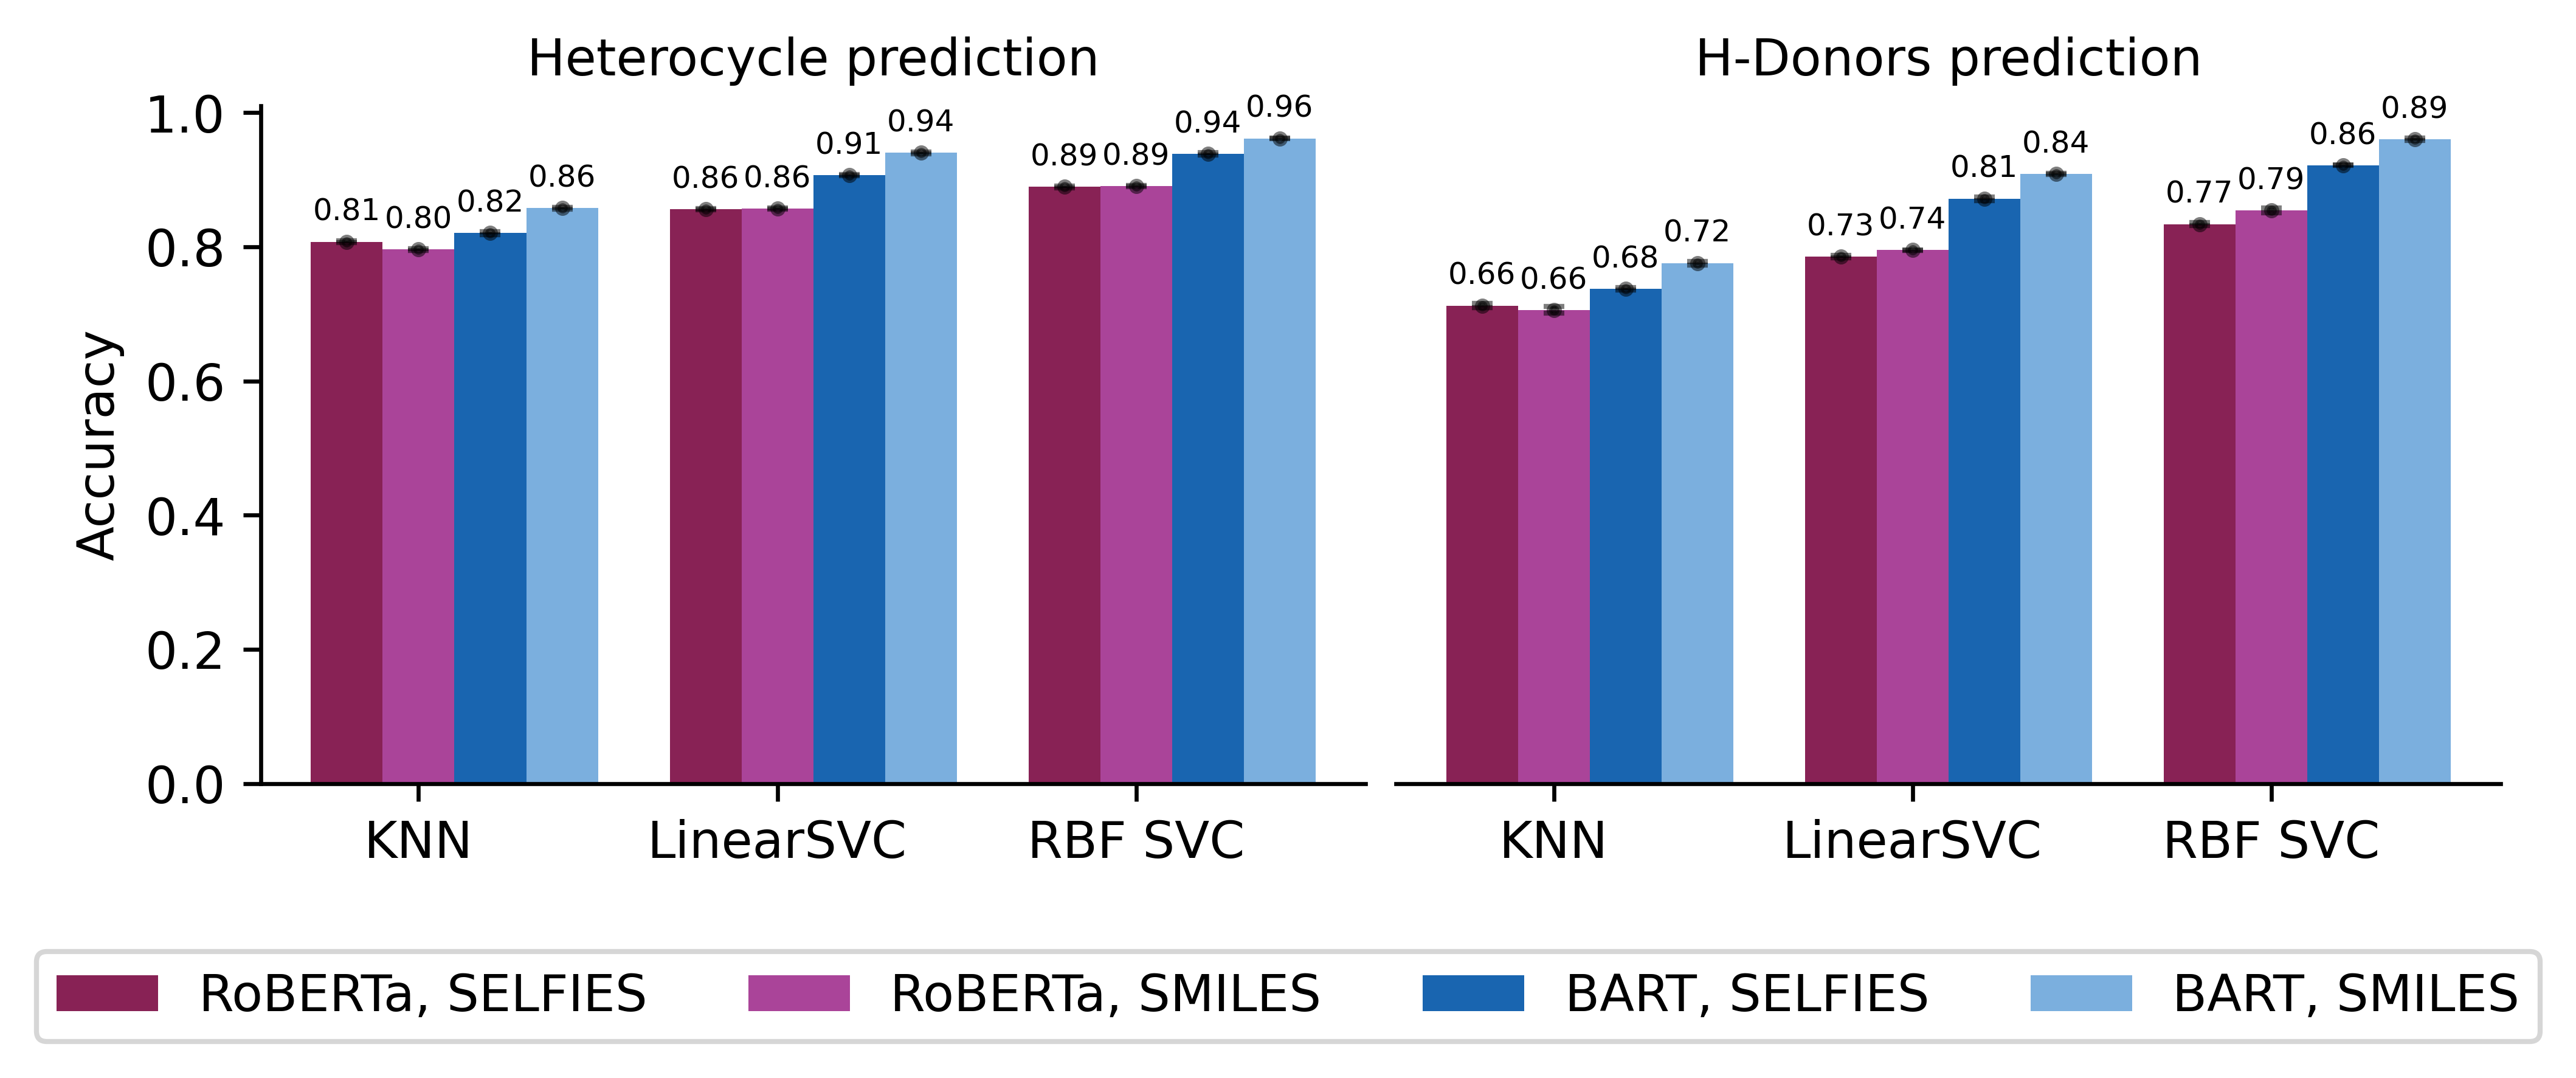

In [106]:
classifiers = ("KNN", "LinearSVC", "RBF SVC")
nice_rows = ["RoBERTa, SELFIES","RoBERTa, SMILES", "BART, SELFIES", "BART, SMILES",]
data_hetero = {nice_rows[it]: vals for it, vals in enumerate(full_pivot[full_pivot.index.isin(interesting_rows)]["best_scores"]["Heterocycles"].sort_values(by=["architecture",'embedding'], ascending=[False,True]).values)}
std_hetero = {nice_rows[it]: vals for it, vals in enumerate(full_pivot[full_pivot.index.isin(interesting_rows)]["std"]["Heterocycles"].sort_values(by=["architecture",'embedding'], ascending=[False,True]).values)}
data_hdonor = {nice_rows[it]: vals for it, vals in enumerate(full_pivot[full_pivot.index.isin(interesting_rows)]["best_scores"]["NumHDonors"].sort_values(by=["architecture",'embedding'], ascending=[False,True]).values)}
std_hdonor = {nice_rows[it]: vals for it, vals in enumerate(full_pivot[full_pivot.index.isin(interesting_rows)]["std"]["NumHDonors"].sort_values(by=["architecture",'embedding'], ascending=[False,True]).values)}

datas = [data_hetero, data_hdonor]
stds = [std_hetero, std_hdonor]
x = np.arange(len(classifiers))  # the label locations
width = 0.2  # the width of the bars

cm = 1/2.54  # centimeters in inches
plt.rcParams['font.size'] = 10
fig, axs = plt.subplots(ncols=2, figsize=(17.1*cm, 6*cm), dpi=600, layout='constrained')
plt.rcParams['font.size'] = 6
for it, ax in enumerate(axs):
    data = datas[it]
    std = stds[it]
    multiplier = 0
    for attribute, measurement in data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        print(std[attribute],)
        ax.errorbar(x + offset, measurement, std[attribute], fmt='.', color='Black', elinewidth=1,capthick=1,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        ax.bar_label(rects, padding=3, fmt='%.2f')
        multiplier += 1
        if it == 0:
            ax.spines[['right', 'top', ]].set_visible(False)
            ax.set_ylabel('Accuracy')
            ax.set_title('Heterocycle prediction', fontsize=10)
        else:
            ax.spines[['right', 'top', "left"]].set_visible(False)
            ax.tick_params(left=[])
            ax.set_yticks([])
            ax.set_title('H-Donors prediction', fontsize=10)
        ax.set_xticks(x + width, classifiers)
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=4, fontsize=10)
plt.savefig(PLOT_PATH/'weak_classifiers_blue.pdf', bbox_inches='tight',dpi=600, transparent=True)
plt.savefig(PLOT_PATH/'weak_classifiers_blue.png', bbox_inches='tight',dpi=600, transparent=True)
plt.show()

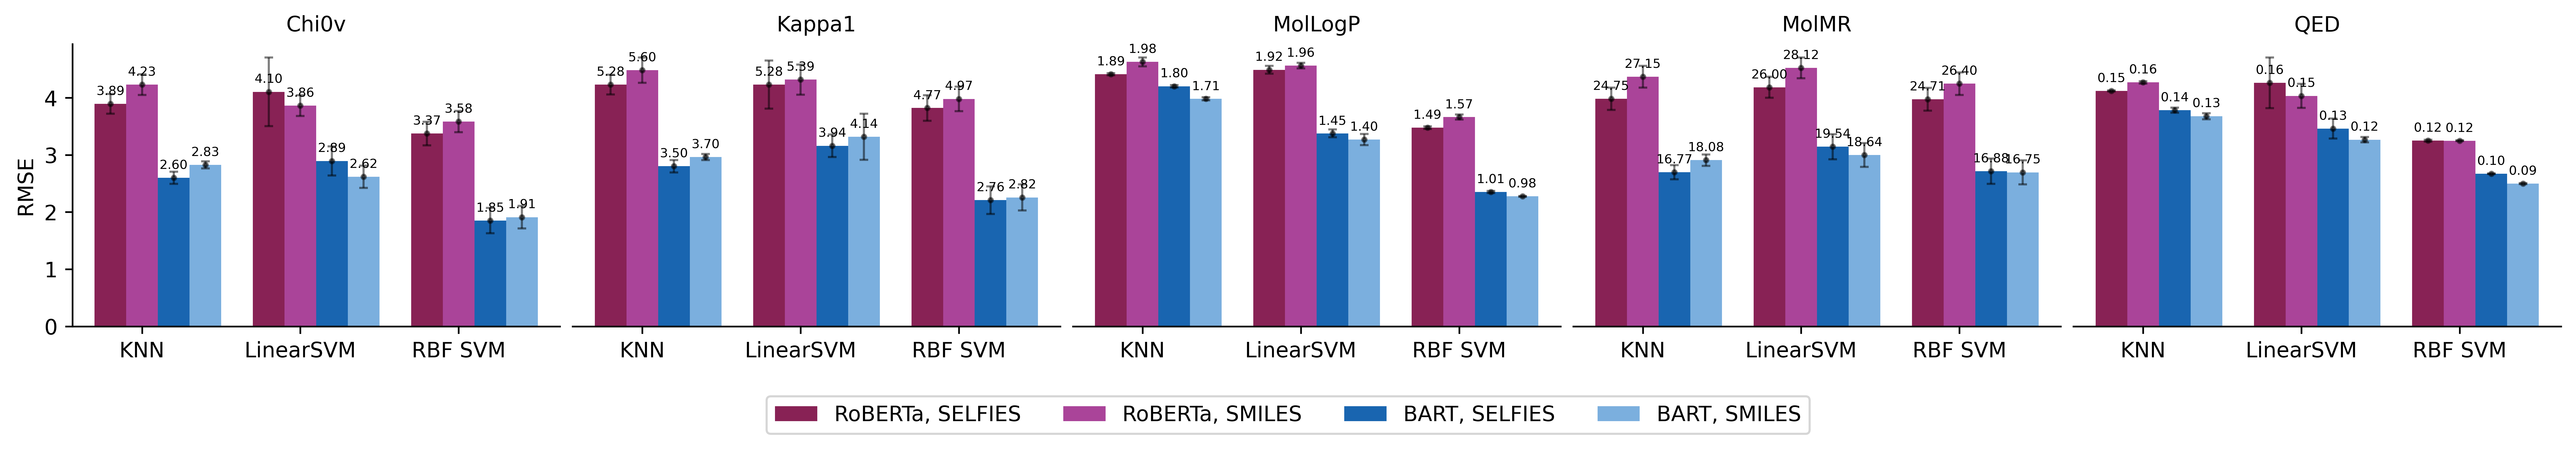

In [110]:
classifiers = ("KNN", "LinearSVM", "RBF SVM")
nice_rows = ["RoBERTa, SELFIES","RoBERTa, SMILES", "BART, SELFIES", "BART, SMILES",]
tasks = ["Chi0v","Kappa1", "MolLogP", "MolMR", "QED"]
data_dict = {}
std_dict = {}
for task in tasks:
    data_dict[task] = {nice_rows[it]: vals for it, vals in enumerate(full_pivot[full_pivot.index.isin(interesting_rows)]["best_scores"][task].sort_values(by=["architecture",'embedding'], ascending=[False,True]).values)}
    std_dict[task] = {nice_rows[it]: vals for it, vals in enumerate(full_pivot[full_pivot.index.isin(interesting_rows)]["std"][task].sort_values(by=["architecture",'embedding'], ascending=[False,True]).values)}
    
datas = [data_hetero, data_hdonor]
stds = [std_hetero, std_hdonor]
x = np.arange(len(classifiers))  # the label locations
width = 0.2  # the width of the bars

cm = 1/2.54  # centimeters in inches
plt.rcParams['font.size'] = 10
fig, axs = plt.subplots(ncols=len(tasks), figsize=(17.1*cm/2*len(tasks), 6*cm), dpi=600, layout='constrained')
plt.rcParams['font.size'] = 6
for it, ax in enumerate(axs):
    task = tasks[it]
    data = data_dict[task]
    std = std_dict[task]
    multiplier = 0
    for attribute, measurement in data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.errorbar(x + offset, measurement, std[attribute], fmt='.', color='Black', elinewidth=1,capthick=1,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        ax.bar_label(rects, padding=3, fmt='%.2f')
        multiplier += 1
        if it == 0:
            ax.spines[['right', 'top', ]].set_visible(False)
            ax.set_ylabel('RMSE')
            ax.set_title(task, fontsize=10)
        else:
            ax.spines[['right', 'top', "left"]].set_visible(False)
            ax.tick_params(left=[])
            ax.set_yticks([])
            ax.set_title(task, fontsize=10)
        ax.set_xticks(x + width, classifiers)
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=4, fontsize=10)
plt.savefig(PLOT_PATH/'other_weak_classifiers_blue.pdf', bbox_inches='tight',dpi=600, transparent=True)
plt.savefig(PLOT_PATH/'other_weak_classifiers_blue.png', bbox_inches='tight',dpi=600, transparent=True)
plt.show()